可能な限り、Mathematicaの実装に近づけて実装

# Import

In [185]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# 座標変換

In [56]:
def w2c(tMatF, deltF, p1sF): # 世界座標系からカメラ座標系への変換
    p1scnvF = [np.dot(npl.inv(tMatF), p1sF[i] - deltF) for i in range(len(p1sF))]
    return np.stack(p1scnvF)

def c2w(tMatF, deltF, p1sF): # カメラ座標系から世界座標系への変換
    p1scnvF = [np.dot(tMatF, p1sF[[i]]) + deltF for i in range(len(p1sF))]
    return np.stack(p1scnvF)

# パラメータ

In [164]:
zvect = np.array((
    (0.15, 0., 1.),
    (-0.25, 0., 1.),
))

yvect = np.array((
    (0., 1., 0.),
    (0., 1., 0.),
))

# ローカル座標系のワールド座標系での原点座標
delt = np.array((
    (0., 0., 0.),
    (1., 0., 0.),
))

ncamera = len(zvect) # カメラ台数

# 変換行列

In [161]:
# initialize
xvecte, yvecte, zvecte = [np.zeros((ncamera,3)) for i in range(3)]
tM = np.zeros((ncamera,3,3))

for ncm in range(ncamera):
    zvecte[ncm] = zvect[ncm] / npl.norm(zvect[ncm]) # normalize
    yvecte[ncm] = yvect[ncm] / npl.norm(yvect[ncm]) # normalize
    
    if ncm==0:
        xvect = np.array([0., 0., -1])
    elif ncm==1:
        xvect = np.array([0., 0., 1])
    
    xvect[0] = np.roots([zvect[ncm][0], np.dot(xvect[1:], zvect[ncm][1:])]) # ≒ Solve
    xvecte[ncm] = xvect / npl.norm(xvect) # normalize
    print("xvect:", xvect)
    print("xvecte:", xvecte[ncm])
    
    for i in range(3):
        tM[ncm] = np.transpose(np.stack([xvecte[ncm], yvecte[ncm], zvecte[ncm]]))
    print()
print("tM:\n",tM)

# print("\ntMが直行行列であることを確認")
# print("\n逆行列:\n",npl.inv(tM))
# print("\n転置行列:\n",np.transpose(tM, (0,2,1)))

xvect: [ 6.66666667  0.         -1.        ]
xvecte: [ 0.98893635  0.         -0.14834045]

xvect: [4. 0. 1.]
xvecte: [0.9701425  0.         0.24253563]

tM:
 [[[ 0.98893635  0.          0.14834045]
  [ 0.          1.          0.        ]
  [-0.14834045  0.          0.98893635]]

 [[ 0.9701425   0.         -0.24253563]
  [ 0.          1.          0.        ]
  [ 0.24253563  0.          0.9701425 ]]]


# Visualization

<IPython.core.display.Javascript object>


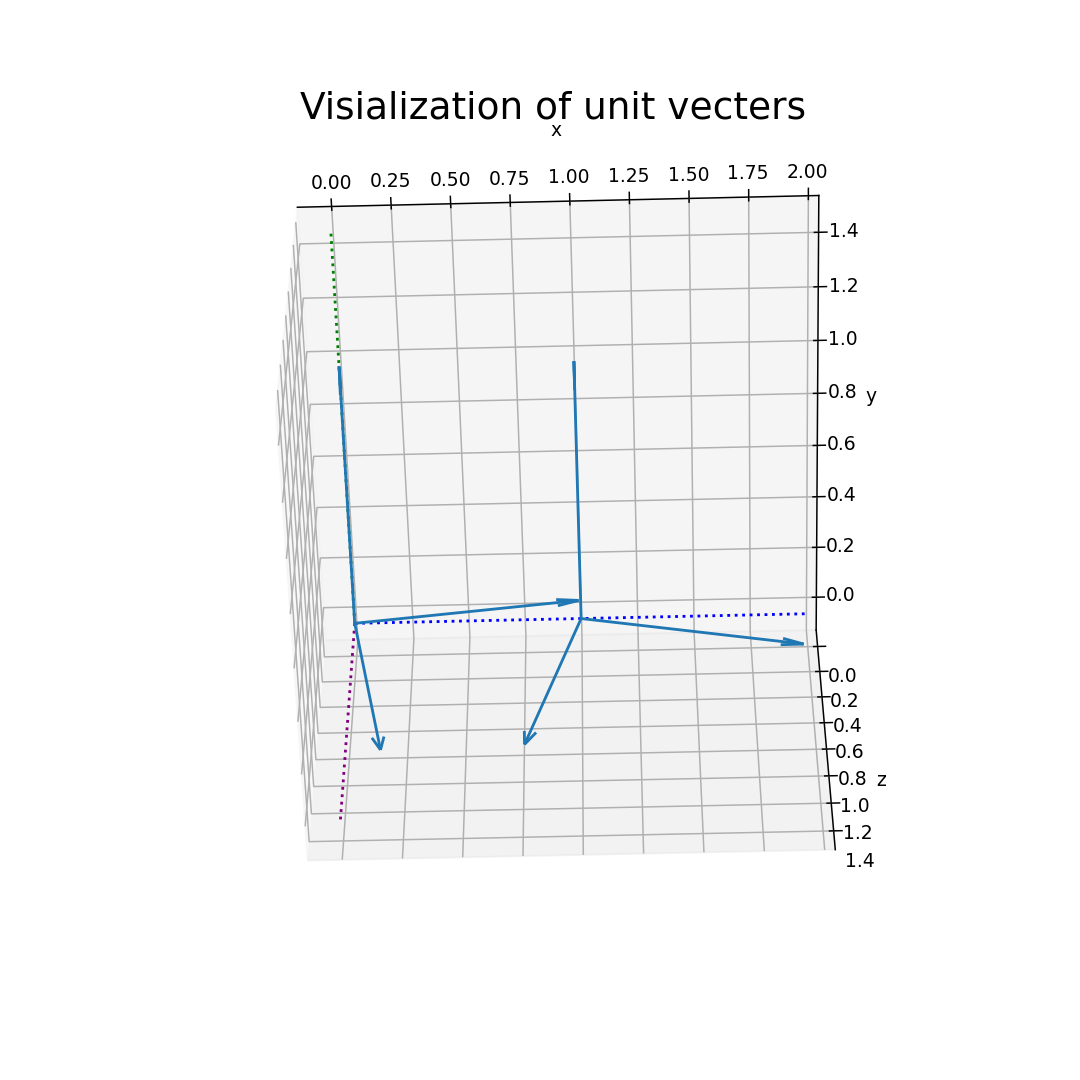

In [183]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3Dプロットの設定

for ncm in range(ncamera):
    for vecte in [xvecte, yvecte, zvecte]:
        start = delt[ncm]
        end = vecte[ncm]
        ax.quiver(*start, *end, arrow_length_ratio=0.1) # 矢印プロット

plt.plot([0, 2],[0, 0], [0, 0],
         color='blue', linestyle=':') # x軸
plt.plot([0, 0],[0, 1.5], [0, 0],
         color='green', linestyle=':') # x軸
plt.plot([0, 0],[0, 0], [0, 1.5],
         color='purple', linestyle=':') # x軸


ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
ax.set_title('Visialization of unit vecters', fontsize=20) # タイトル
# ax.legend() # 凡例
ax.set_xlim(-0.1, 2) # x軸の表示範囲
ax.set_ylim(-0.1, 1.5) # y軸の表示範囲
ax.set_zlim(-0.1, 1.5) # z軸の表示範囲
plt.show()

# 

In [255]:
# ターゲットのイメージを作る

tgposzFront = 3.5 - 0.9 # 前面のz座標 [m]
tgposzRear = 4.0 - 0.9 # 後面のz座標 [m]

tgposxy = np.concatenate([np.array([[x,y] for y in [0.0, 1.0, 0.05]]) for x in [0.5, 1.5, 0.05]])
tgposxy = np.concatenate([np.array([[x,y] for y in [0.0, 1.0, 0.1]]) for x in [0.5, 1.5, 0.05]]) # この時に誤差が小さい
tgposxy = np.concatenate([np.array([[x,y] for y in [-1.0, 1.0, 0.5]]) for x in [-1.0, 1.5, 0.5]])
tgposxy = np.concatenate([np.array([[x,y] for y in [-0.5, 0.5, 0.2]]) for x in [0.25, 0.8, 0.1]]) # z=2.6~4.9 意外と誤差が小さい
tgposxy = np.concatenate([np.array([[x,y] for y in [-0.5, 0.5, 0.25]]) for x in [0.25, 1.25, 0.25]]) # この時に誤差が小さい
tgposxy = np.concatenate([np.array([[x,y] for y in [-0.5, 0.5, 0.25]]) for x in [-0.5, 0.5, 0.25]])

tgpos = np.stack([[*tgposxy.T, np.repeat(tgpz, len(tgposxy))] for tgpz in [tgposzFront, tgposzRear]]).transpose(0,2,1) # 個数は同じにすること
nplain = len(tgpos) # 平面数

foculL = 0.1 # カメラ1の焦点距離
rez = (4000, 3000) # 画素数
fov = np.radians([60, 45]) # 画角
pixelRez = (2*foculL*np.tan(fov/2))/rez # 画素分解能 スクリーン面での

print("pixelRez = ", pixelRez)
print("Screen[m] ", (2*foculL*np.tan(fov/2)))

# initialize
tgCxy = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
tgCuv = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
dltp, dltp2 = [np.zeros((ncamera,11)) for i in range(2)]
gg = [None for i in range(ncamera)]

for ncm in range(ncamera):
    # npはnumpyで使われていたため、変数名をnpsに変更
    for nps in range(nplain): # 2平面なので
        # カメラ座標系へ
        cnvw2c = w2c(tM[ncm], delt[ncm], tgpos[nps])
        
        # カメライメージ
        for j in range(len(cnvw2c)):
            k = (foculL - 0) / (cnvw2c[j, 2] - 0)
            tgCxy[ncm,nps,j] = cnvw2c[j,:2] * k # (x,y)
            tgCuv[ncm,nps,j] = np.round(tgCxy[ncm,nps,j]/pixelRez) # (u,v)

    # 可視化パートはよくわからなかったので、いったん保留する
    
    # DLT 11パラメータを求める
    tg = np.concatenate(tgpos) # flattenにレベルを指定できないため、concatenateかreshapeで対応
    ntgp = len(tg)
    uv = np.concatenate(tgCuv[ncm])
    aMat = np.zeros((ntgp*2,11))
    bMat = np.zeros((ntgp*2,))
    
    for n in range(ntgp):
        x, y, z, u, v = tg[n,0], tg[n,1], tg[n,2], uv[n,0], uv[n,1]
        aMat[2*n]   = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]
        aMat[2*n+1] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z]
        bMat[2*n]   = u
        bMat[2*n+1] = v
        
    print("\nDimensions:\naMat.shape\n", aMat.shape, "\nbMat.shape\n", bMat.shape)
#     print("\naMat:\n",aMat)
#     print("\nbMat:\n",bMat)
    dltp[ncm] = np.dot(npl.pinv(aMat), bMat)
    dltp2[ncm] = np.dot(npl.inv(np.dot(aMat.T, aMat)), np.dot(aMat.T, bMat))

uvmemo = uv

print("\ndltp:\n",dltp)
print("\ndltp2:\n", dltp2)
print("\nDifference:\n", dltp-dltp2)
print("\nMax of Difference:\n", np.max(dltp-dltp2))

aMat = np.zeros((ntgp*2,11))
bMat = np.zeros((ntgp*2,))

tguv = 

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (36, 11) 
bMat.shape
 (36,)

Dimensions:
aMat.shape
 (36, 11) 
bMat.shape
 (36,)

dltp:
 [[ 9.60536736e+04 -1.63704255e+00 -1.42186740e+04 -5.45636836e+02
  -1.49669591e+01  1.01564950e+05 -3.50721867e+01  1.03842577e+02
   4.17462797e+00  3.82635580e-03  2.73826458e+01]
 [ 1.39921986e+04  2.58058058e-02  3.48507029e+03 -1.39566558e+04
  -3.28663369e+00  1.50747700e+04  8.45398864e-01 -2.11098056e+00
  -1.01363609e+00 -1.16856480e-04  4.04127126e+00]]

dltp2:
 [[ 9.60536736e+04 -1.63704254e+00 -1.42186740e+04 -5.45636816e+02
  -1.49669592e+01  1.01564950e+05 -3.50721866e+01  1.03842576e+02
   4.17462797e+00  3.82635579e-03  2.73826458e+01]
 [ 1.39921986e+04  2.58057953e-02  3.48507029e+03 -1.39566558e+04
  -3.28663370e+00  1.50747700e+04  8.45398864e-01 -2.11098056e+00
  -1.01363609e+00 -1.16856478e-04  4.04127126e+00]]

Difference:
 [[ 3.86107131e-05 -1.78840083e-08 -1.75278001e-06 

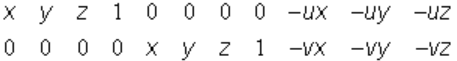

In [246]:
dltp2

array([ 1.39921986e+04,  2.58057953e-02,  3.48507029e+03, -1.39566558e+04,
       -3.28663370e+00,  1.50747700e+04,  8.45398864e-01, -2.11098056e+00,
       -1.01363609e+00, -1.16856478e-04,  4.04127126e+00])

In [235]:
[x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]

[-0.5, -0.5, 2.6, 1, 0, 0, 0, 0, -610.5, -610.5, 3174.6]

<IPython.core.display.Javascript object>


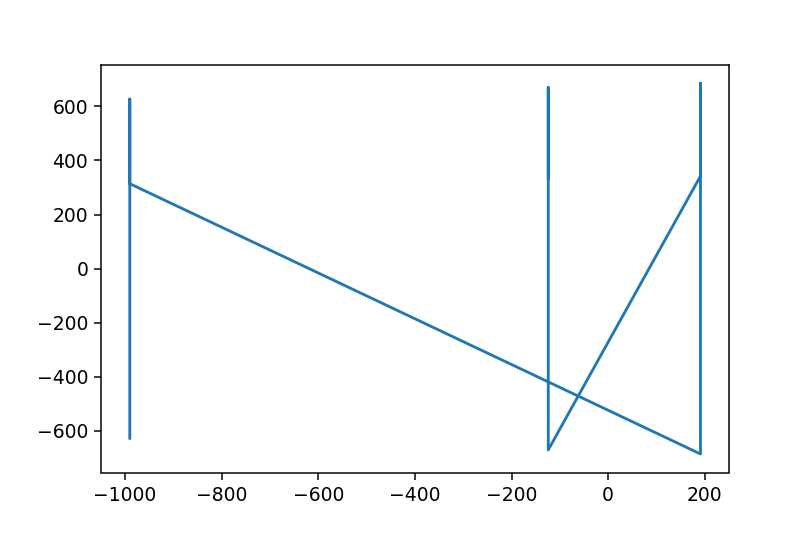

In [223]:
fig, ax = plt.subplots(1)
ax.plot(tgCuv[ncm,0].T[0], tgCuv[ncm,0].T[1])

In [226]:
np.concatenate(tgpos)

array([[-0.5 , -0.5 ,  2.6 ],
       [-0.5 ,  0.5 ,  2.6 ],
       [-0.5 ,  0.25,  2.6 ],
       [ 0.5 , -0.5 ,  2.6 ],
       [ 0.5 ,  0.5 ,  2.6 ],
       [ 0.5 ,  0.25,  2.6 ],
       [ 0.25, -0.5 ,  2.6 ],
       [ 0.25,  0.5 ,  2.6 ],
       [ 0.25,  0.25,  2.6 ],
       [-0.5 , -0.5 ,  3.1 ],
       [-0.5 ,  0.5 ,  3.1 ],
       [-0.5 ,  0.25,  3.1 ],
       [ 0.5 , -0.5 ,  3.1 ],
       [ 0.5 ,  0.5 ,  3.1 ],
       [ 0.5 ,  0.25,  3.1 ],
       [ 0.25, -0.5 ,  3.1 ],
       [ 0.25,  0.5 ,  3.1 ],
       [ 0.25,  0.25,  3.1 ]])